# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [2]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [5]:
from utils import config
from utils.config import PAPER_STYLE

/home/camilo/Repositorios/ml-healthcare-project/utils/config.py:64: UserWarning: opentsne is not available. Using sklearn.manifold.TSNE instead.
  warn("opentsne is not available. Using sklearn.manifold.TSNE instead.")


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn import linear_model, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_classif,
    f_regression,
    mutual_info_classif,
    mutual_info_regression,
)
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    GammaRegressor,
    Lasso,
    LassoLars,
    LinearRegression,
    LogisticRegression,
    PassiveAggressiveClassifier,
    PassiveAggressiveRegressor,
    Ridge,
    RidgeClassifier,
    SGDClassifier,
    SGDRegressor,
    TweedieRegressor,
)
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    quantile_transform,
)
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR, NuSVC, NuSVR
from sklego.meta import ZeroInflatedRegressor

from utils import experiments, helpers
from utils import metrics as my_metrics
from utils import plots, scorers
from utils import statistical as st
from utils import tuning
from utils.param_grids import (
    choose_param_grid,
    combine_param_grids,
    make_smaller_param_grid,
    construct_param_grids_list,
)
from utils.transformers import PolynomialColumnTransformer

# Use cuML to use GPU-accelerated models
USE_CUML = False

# Run sections of this notebook that take a long time
RUN_REG_Y_IS_0 = False
RUN_REG_Y_GE_0 = False

# True if no plots should be displayed
NO_PLOTS = False

if config.CUML_INSTALLED and USE_CUML:
    from cuml import LogisticRegression, MBSGDClassifier, MBSGDRegressor
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.kernel_ridge import KernelRidge
    from cuml.linear_model import Lasso, LinearRegression, Ridge
    from cuml.svm import SVC, SVR

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

# Dedicate a fraction of the data for testing (validation is taken care of by CV)
TEST_SIZE = 0.2

# Define a RANDOM_STATE to make outputs deterministic
RANDOM_STATE = 42
helpers.seed_everything(RANDOM_STATE)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [7]:
df_train = pd.read_csv("data/train.csv")
df_train.drop(columns=[CLF_TARGET], inplace=True) # drop the classification target

print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 109 columns


In [8]:
df_train.head()

RACE  SEX  PANEL        WEIGHT  STUDENT_STAT  MIL_ACTIV_DUTY  \
0  Non-White    1     19   7205.036720            -1               2   
1      White    1     20   5501.113581            -1               4   
2      White    1     20  16797.708379            -1               4   
3  Non-White    2     19   3605.218411            -1               2   
4  Non-White    1     19  11223.127404             1               2   

   HON_DISCHARGE  HEALTH_STAT  MENTAL_HLTH  CHRON_BRONCH  ...  ADHD_DIAG  \
0              2            2            2             2  ...         -1   
1              2            1            1             2  ...         -1   
2              1            3            1             2  ...         -1   
3              2            3            3             2  ...         -1   
4              2            1            2             2  ...          2   

   NUM_PRESCR_MEDS  DIFFIC_HEAR  DIFFIC_SEE  SMOK  OVR_FEEL_14  \
0                0            2           2     2            1   
1               12            2           2     2            0   
2               20            2           2     2            0   
3               20            2           2     2            0   
4                3            2           2     2            0   

   MENTAL_HLTH_SCR  PHY_HLTH_SCR  OVR_FEEL_30  TOT_MED_EXP  
0            43.82         61.41            3            0  
1            60.12         54.80            0          240  
2            60.35         30.08            0          791  
3            58.32         50.22            0          272  
4            62.39         56.71            0         1264  

[5 rows x 109 columns]

In [9]:
# Handling missing values
total_missing_values = df_train.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


## Data exploration

In [10]:
df_train_mirror = df_train.copy()

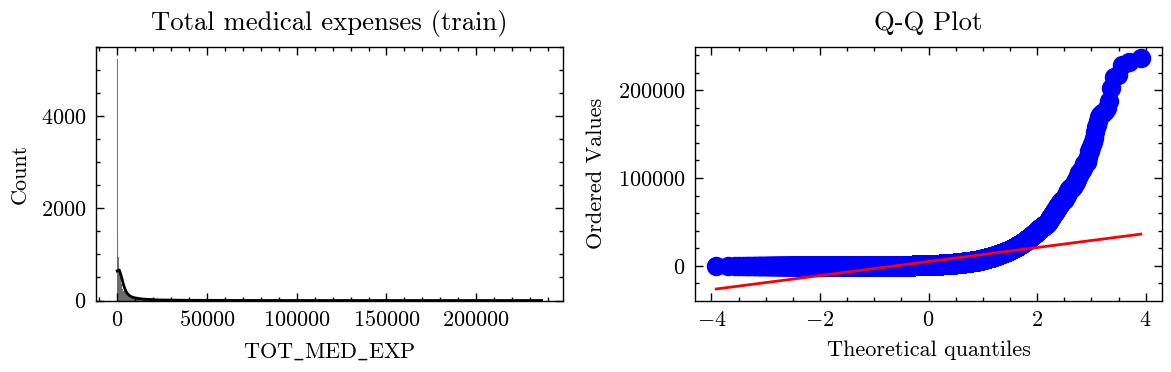

Original data summary:
	Minimum: 0.0000
	Maximum: 236449.0000
	Mean: 4931.6669
	Standard Deviation: 12802.5923
	Number of Zeros: 2980
Transformed data summary:
	Minimum: 0.0000
	Maximum: 236449.0000
	Mean: 4931.6669
	Standard Deviation: 12802.5923
	Number of Zeros: 2980


In [11]:
if not NO_PLOTS:
    st.plot_distribution_fits(
        df_train_mirror,
        REG_TARGET,
        distribution=None,
        style=PAPER_STYLE,
        stat="count",
        titles=["Total medical expenses (train)"],
    )

In [12]:
print(
    helpers.describe_cols(
        df_train_mirror,
        dummy_is_categorical=False,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                       Value Counts                       |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            | {'Non-White': '8754 (58.36%)', 'White': '6246 (41.64%)'} |
|        ACTIV_LIM        |  Numerical  |   1.862   |       0.625        | -8.000 |   2.000   |   2.000   |   2.000   |   2.000    |                                                          |
|        ADHD_DIAG        |  Numerical  

In [13]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    df_train_mirror.drop(columns=[REG_TARGET]),
    consecutive_sequences_are_categorical=False,
    low_unique_int_values_are_categorical=False,
)

# One-Hot encoding for categorical columns (with non-numeric values only)
categorical_encoder, df_train_mirror = helpers.handle_categorical_cols(
    df_train_mirror, categorical_cols, return_only_encoded=False
)
df_train_mirror = df_train_mirror.copy()

print(f"Numerical ({len(numerical_cols)}) ", numerical_cols)
print(f"Categorical ({len(categorical_cols)}): ", categorical_cols)
print(f"Number of columns after one-hot encoding: {df_train_mirror.shape[1]}")

Numerical (107)  ['DIAB_INSLN', 'EDU_DEG', 'PHY_HLTH_SCR', 'OCCUP', 'NON_ENG_LANG', 'TAX_FORM_TYP', 'FOOD_STMP_MNTHS', 'HRT_ATT_DIAG', 'HIGH_BP_DIAG', 'DAYS_ILL_NOWORK', 'SOCIAL_LIM', 'ADV_NO_SMKG', 'AGE', 'ADV_EAT_HLTHY', 'WEAR_SEATBLT', 'DIAB_KIDNY', 'FOOD_STMP_VAL', 'ASPRN_REG', 'MENTAL_HLTH_SCR', 'UNABL_PRES_MED', 'WEIGHT', 'MULT_HIGHBP', 'OVR_FEEL_30', 'BM_IDX', 'DIFF_ERRND_ALN', 'LAST_REG_CKP', 'STROKE_DIAG', 'CANCER_DIAG', 'TIME_LAST_PSA', 'DIFFIC_HEAR', 'JNT_PAIN', 'ASTHM_DIAG', 'SPOUSE_PRSNT', 'DELAY_PRESCR_MED', 'DAYS_ILL_NOSCHL', 'SEX', 'PROB_WKIDS', 'HEAR_AID', 'LAST_FLU_VAC', 'PREGNT', 'CHRON_BRONCH', 'OVR_FEEL_14', 'HEALTH_STAT', 'PUB_ASST', 'EMPLYMT', 'EMPHYM_DIAG', 'FREQ_DNTL_CKP', 'ADV_NO_FAT_FOOD', 'DOC_CK_BP', 'WHEN_ADV_BOOST_SEAT', 'RSN_NO_DNTL_CKP', 'ADV_LAP_BLT', 'ANGINA_DIAG', 'ARTHR_DIAG', 'MARITAL_STAT', 'DOC_TIM_ALN', 'SMOK', 'ADV_BOOST_SEAT', 'PROB_WBHV', 'BLIND', 'FEEL_DEPRS', 'MENTAL_HLTH', 'SCHOOL_LIM', 'POVRTY_LEV', 'NUM_DEP_OUT_REP_UNT', 'DIAB_MED', 'CHI

In [14]:
# Only RACE_White is the new column
# If 1.0, the person is white, otherwise not
df_train_mirror.rename(columns={"RACE_White": "RACE"}, inplace=True)

print(
    helpers.describe_cols(
        df_train_mirror,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                 Value Counts                 |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            | {0.0: '8754 (58.36%)', 1.0: '6246 (41.64%)'} |
|        ACTIV_LIM        |  Numerical  |   1.862   |       0.625        | -8.000 |   2.000   |   2.000   |   2.000   |   2.000    |                                              |
|        ADHD_DIAG        |  Numerical  |   -0.922  |       0.483        | -9.000 |   -1.000  |   -1

### *Variance Threshold Analysis*

In [15]:
VARIANCE_THRESHOLD = 0.01  # Drop (quasi-constant) columns with variance < 0.01

# Don't include the target variable in the variance thresholding obviously
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])

var_thresh = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
var_thresh.fit(df_train_without_reg_target)
low_variance_cols = df_train_without_reg_target.columns[~var_thresh.get_support()].tolist()
print(f"Columns with var < {VARIANCE_THRESHOLD} ({len(low_variance_cols)}): ", low_variance_cols)

df_train_mirror.drop(columns=low_variance_cols, inplace=True)
print(f"Number of columns after dropping low variance columns: {df_train_mirror.shape[1]}")

# Remove the low variance columns from the categorical and numerical columns
numerical_cols = helpers.filter_values(numerical_cols, low_variance_cols)
categorical_cols = helpers.filter_values(categorical_cols, low_variance_cols)

Columns with var < 0.01 (2):  ['ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT']
Number of columns after dropping low variance columns: 107


### *Skewness Analysis*

In [16]:
# Find Skewed Features in columns that are most definitely numerical
_, definitely_numerical_cols = helpers.categorical_and_numerical_columns(
    df_train_mirror.drop(columns=[REG_TARGET]),
    dummy_is_categorical=True,
    consecutive_sequences_are_categorical=True,
    low_unique_int_values_are_categorical=True,
)

skewed_feats = (
    df_train[definitely_numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
)
print("\nSkew in numerical columns: \n")
skewed_numerical_cols = pd.DataFrame({"Skew": skewed_feats})
print(skewed_numerical_cols.head(10))

skewed_numerical_cols = skewed_numerical_cols[abs(skewed_numerical_cols) > 0.75]
print("\nThere are {} skewed numerical columns".format(skewed_numerical_cols.shape[0]))

skewed_numerical_cols = skewed_numerical_cols.index.tolist()

2024-08-19 22:10:57,071 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'UNION_STAT', 'DEAF', '

In [17]:
# Apply a Yeo-Johnson transformation to skewed features
df_train_mirror[skewed_numerical_cols] = PowerTransformer(method="yeo-johnson").fit_transform(
    df_train_mirror[skewed_numerical_cols]
)

### *Correlation Analysis*


Found 6 cols with correlation >= 0.9
['SCHOOL_LIM', 'PROB_WBHV', 'ADV_EAT_HLTHY', 'POVRTY_LEV', 'UNION_STAT', 'UNABL_PRES_MED']


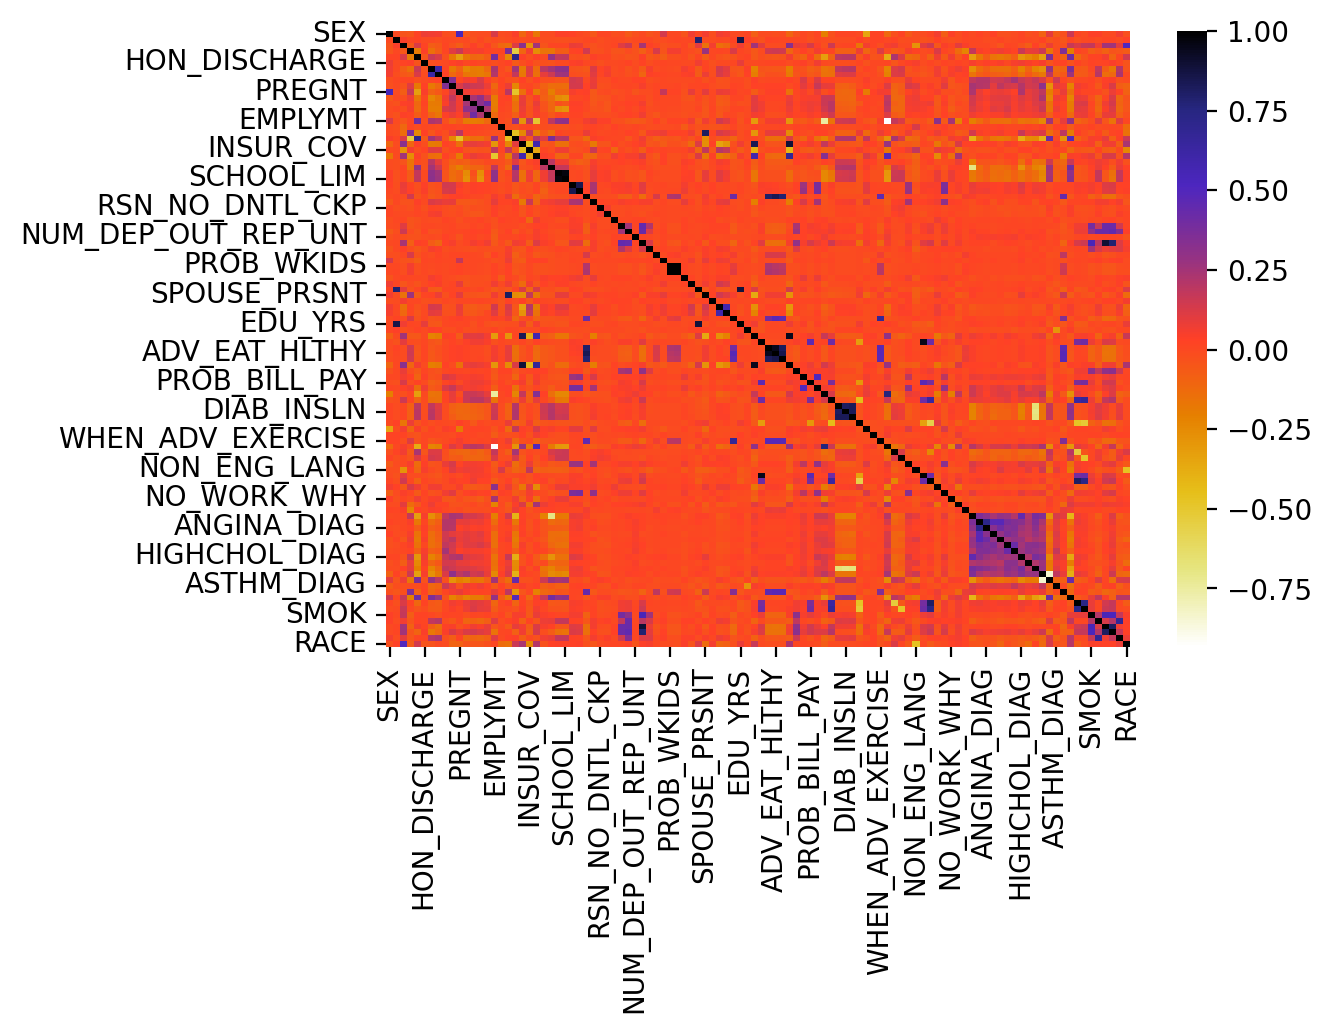

+----------------------------------------------------------------------+
|                         Correlation Summary                          |
+-------------------+------------------+---------------------+---------+
| Correlated Column | Correlated With  |     Correlation     | p-value |
+-------------------+------------------+---------------------+---------+
|     UNION_STAT    |     EMPLYMT      | -0.9335300079044023 |   0.0   |
|     SCHOOL_LIM    |   HOUSEWRK_LIM   |  0.9769131590922299 |   0.0   |
|     PROB_WBHV     |    PROB_WKIDS    |  0.9971318581558912 |   0.0   |
|     POVRTY_LEV    |    FAM_INCOME    |  0.9416967980099031 |   0.0   |
|   UNABL_PRES_MED  | DELAY_PRESCR_MED |  0.9492157211126457 |   0.0   |
|   ADV_EAT_HLTHY   |   ADV_LAP_BLT    |  0.9432248025238906 |   0.0   |
+-------------------+------------------+---------------------+---------+
Number of columns after dropping correlated columns: 101


In [18]:
# Get the correlation matrix of the data (excluding the regression and classification targets!)
# Find the columns that are highly correlated with each other and remove them
CORRELATION_THRESHOLD = 0.9  # 90% correlation threshold

df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
correlated_cols, corr, summary = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

print(f"\nFound {len(correlated_cols)} cols with correlation >= {CORRELATION_THRESHOLD}")
print(correlated_cols)

if not NO_PLOTS:
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, cmap=plt.cm.CMRmap_r)
    plt.show()

summary_table = helpers.make_pretty_table(
    summary,
    ["Correlated Column", "Correlated With", "Correlation", "p-value"],
    title="Correlation Summary",
)
print(summary_table)

df_train_mirror.drop(columns=correlated_cols, inplace=True)
print(f"Number of columns after dropping correlated columns: {df_train_mirror.shape[1]}")

2024-08-19 22:11:01,663 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'DEAF', 'BLIND', 'LAST_FLU_VAC', 'NON_ENG_LANG', 'HEAR_AID', 'PENSN

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:414: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


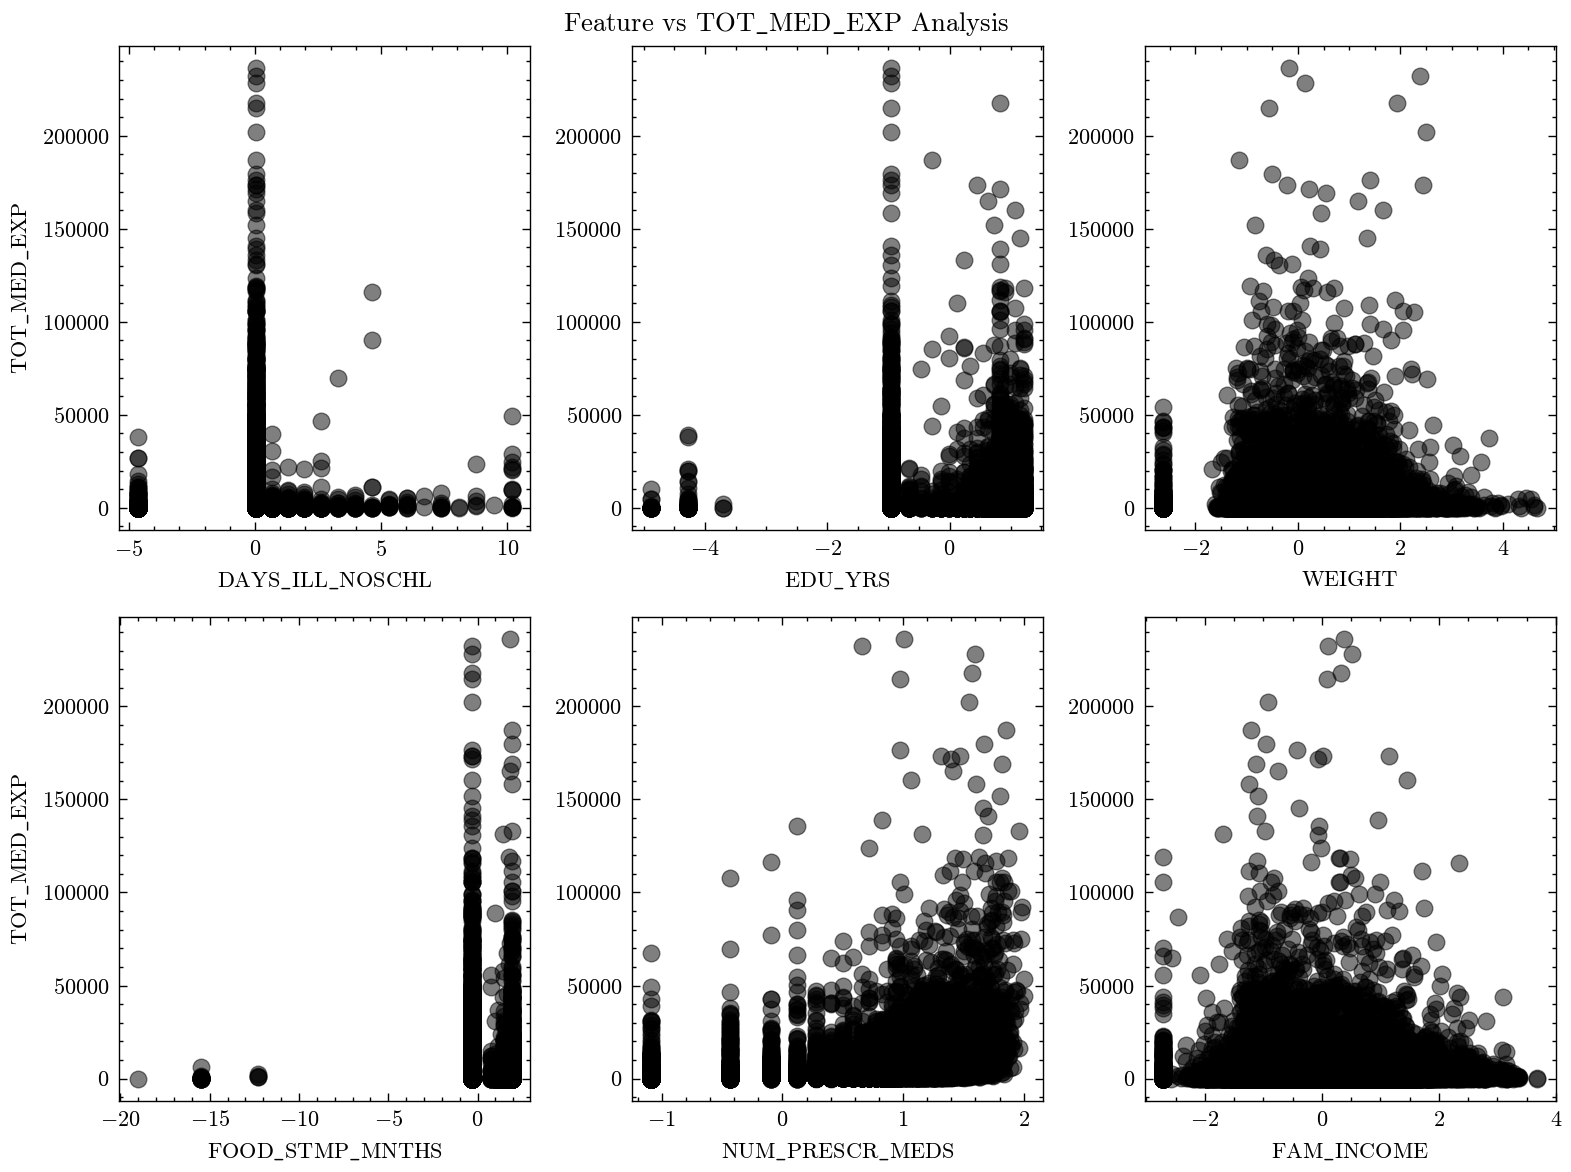

In [19]:
if not NO_PLOTS:
    plots.plot_features_vs_target(
        df_train_mirror, REG_TARGET, style=PAPER_STYLE, n_features=6, max_rows=2
    )

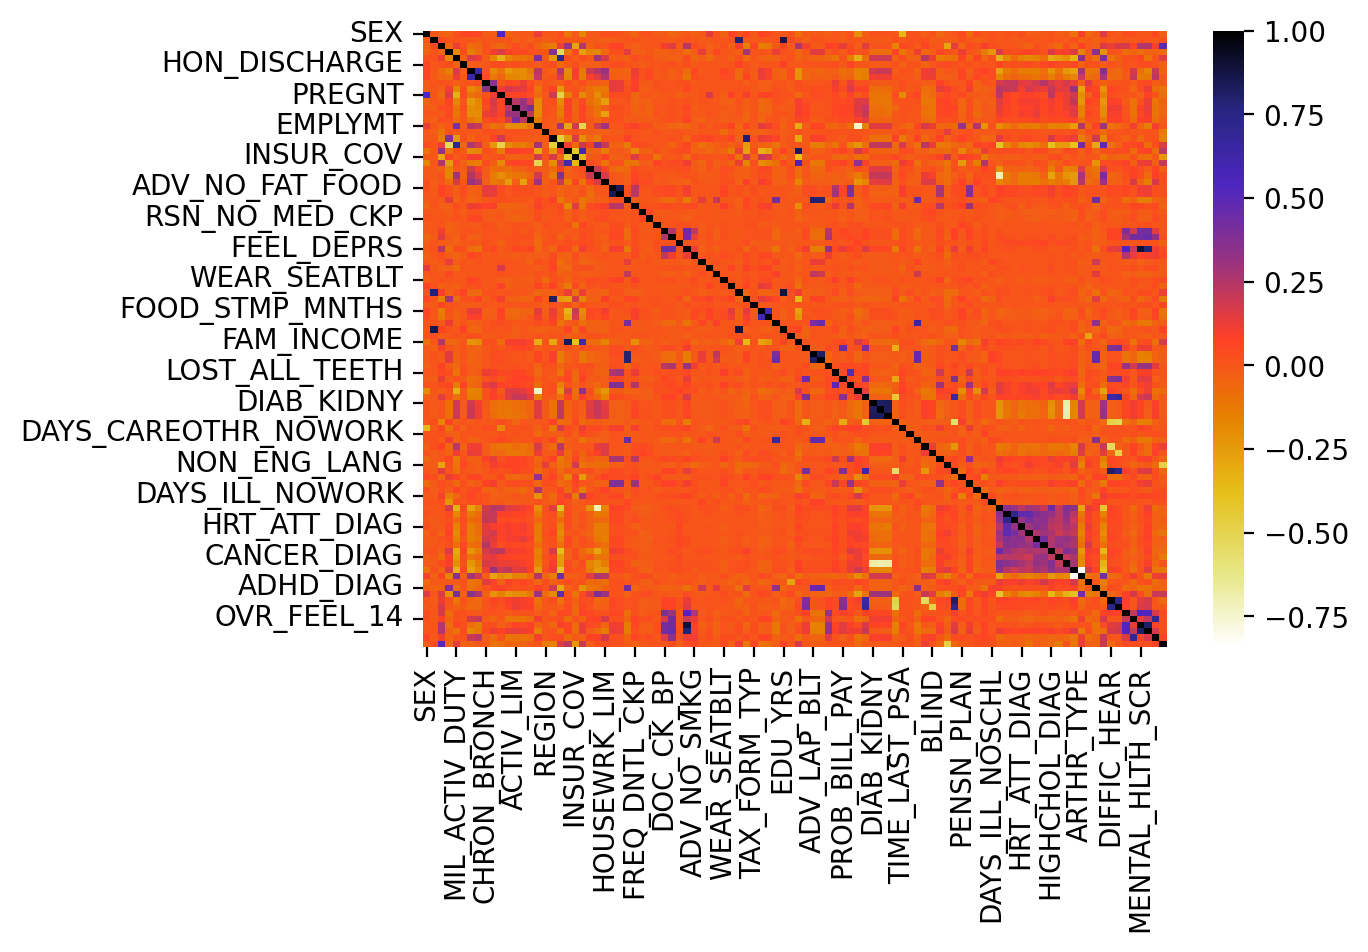

In [20]:
# After Feature Selection
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
_, new_corr, _ = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

if not NO_PLOTS:
    plt.figure(figsize=(6, 4))
    sns.heatmap(new_corr, cmap=plt.cm.CMRmap_r)
    plt.show()

### *One-Hot Encoding of Likely Categorical Features*


In [21]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    # Drop the target variable and other columns that will be dropped during training
    df_train.drop(columns=[REG_TARGET] + correlated_cols + low_variance_cols), 
    dummy_is_categorical=True,
    consecutive_sequences_are_categorical=True,
    low_unique_int_values_are_categorical=True,
)

categorical_encoder, df_train = helpers.handle_categorical_cols(
    df_train, categorical_cols, return_only_encoded=False
)

print(
    helpers.describe_cols(
        df_train,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=True,
        low_unique_int_values_are_categorical=True,
    )
)

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")

2024-08-19 22:11:06,766 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'DEAF', 'BLIND', 'LAST_FLU_VAC', 'NON_ENG_LANG', 'HEAR_AID', 'PENSN

### *Outlier Detection*

In [22]:
# outliers = st.detect_outliers(df_train_mirror, column_name=REG_TARGET, method="modified-z-score")
# outliers = st.detect_outliers(
#     df_train_mirror,
#     column_name=REG_TARGET,
#     method="iqr",
#     iqr_lower_percentile=1,
#     iqr_upper_percentile=99,
# )
# outliers = st.detect_outliers(df_train_mirror, method="isolation-forest")
# print(f"Found {outliers.sum()} outliers of {df_train.shape[0]} samples")

# Drop the outliers
# df_train = df_train[~outliers]
# df_train_mirror = df_train_mirror[~outliers]
# print(f"Number of samples after dropping outliers: {df_train_mirror.shape[0]}")

In [23]:
# Split into features and target for regression and classification
X = df_train.drop(columns=[REG_TARGET])
y_regression = df_train[REG_TARGET]

# **Linear regression**

In this part, we will solve an linear regression task to predict our target `TOT_MED_EXP`, i.e. total medical expences, using the other features.


In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized using the cost function

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

### Setup

In [24]:
RUNS_DIR = "regression_task_runs"
CLF_IS_0_DIR = os.path.join(RUNS_DIR, "clf_is_0")
REG_GE_0_DIR = os.path.join(RUNS_DIR, "reg_ge_0")
REG_DIR = os.path.join(RUNS_DIR, "reg")

helpers.ensure_directory_exists(RUNS_DIR)
helpers.ensure_directory_exists(CLF_IS_0_DIR)
helpers.ensure_directory_exists(REG_GE_0_DIR)
helpers.ensure_directory_exists(REG_DIR)

### Process the data

In [25]:
print("The dataset now has {} rows and {} columns".format(X.shape[0], X.shape[1]))

# Split X and y for training and validation purposes
X_train_reg, X_test_reg, y_train_reg, y_test_reg = helpers.make_train_test_split(
    X, y_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

The dataset now has 15000 rows and 412 columns
Training shape: (12000, 412)
Testing shape: (3000, 412)


### Train a classifier for `y = 0` and `y > 0`
Since the data is highly right-skewed, i.e, too many zeroes, we can first train a classifier to find out whether the target value is zero or not. If the target value is zero, we can directly predict the output as zero. If the target value is greater than zero, we can train a linear regression model to predict the target value.

The classifier will answer the question: "Should the output be zero?" - That is, `y = 1 (True)` for `y = 0` and `y = 0 (False)` for `y > 0`.

In [26]:
# Split into features and target
df_train_y_is_0 = df_train.copy()
df_train_y_is_0[REG_TARGET] = df_train_y_is_0[REG_TARGET].apply(lambda x: 1 if x == 0 else 0)

X_is_0_clf = df_train_y_is_0.drop(columns=[REG_TARGET])
y_is_0_clf = df_train_y_is_0[REG_TARGET].astype(int)

# Count the number of positive and negative samples
pos_samples = (y_is_0_clf == 1).sum()
neg_samples = (y_is_0_clf == 0).sum()

# Split X and y for training and validation purposes
X_is_0_clf_train, X_is_0_clf_test, y_is_0_clf_train, y_is_0_clf_test = (
    helpers.make_train_test_split(
        X_is_0_clf, y_is_0_clf, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
)

Training shape: (12000, 412)
Testing shape: (3000, 412)


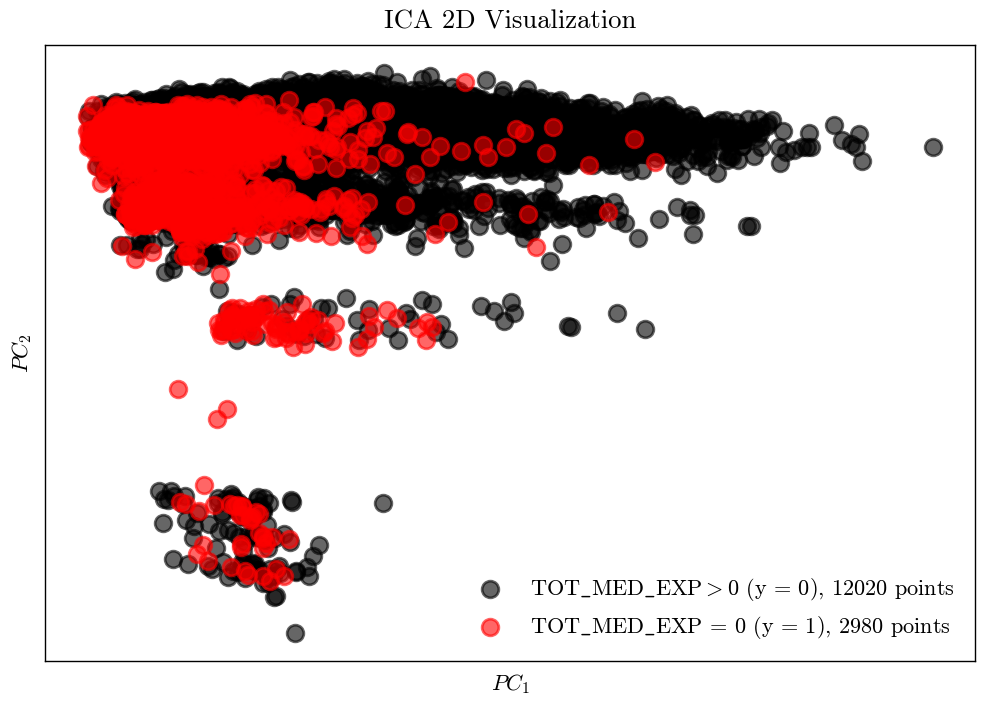

In [27]:
if not NO_PLOTS:
    plots.visualize(
        X_is_0_clf,
        n_components=2,
        method="ica",
        indices=[y_is_0_clf == 0, y_is_0_clf == 1],
        labels=[
            f"TOT_MED_EXP$>$0 (y = 0), {neg_samples} points",
            f"TOT_MED_EXP = 0 (y = 1), {pos_samples} points",
        ],
        style=PAPER_STYLE,
    )

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:414: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


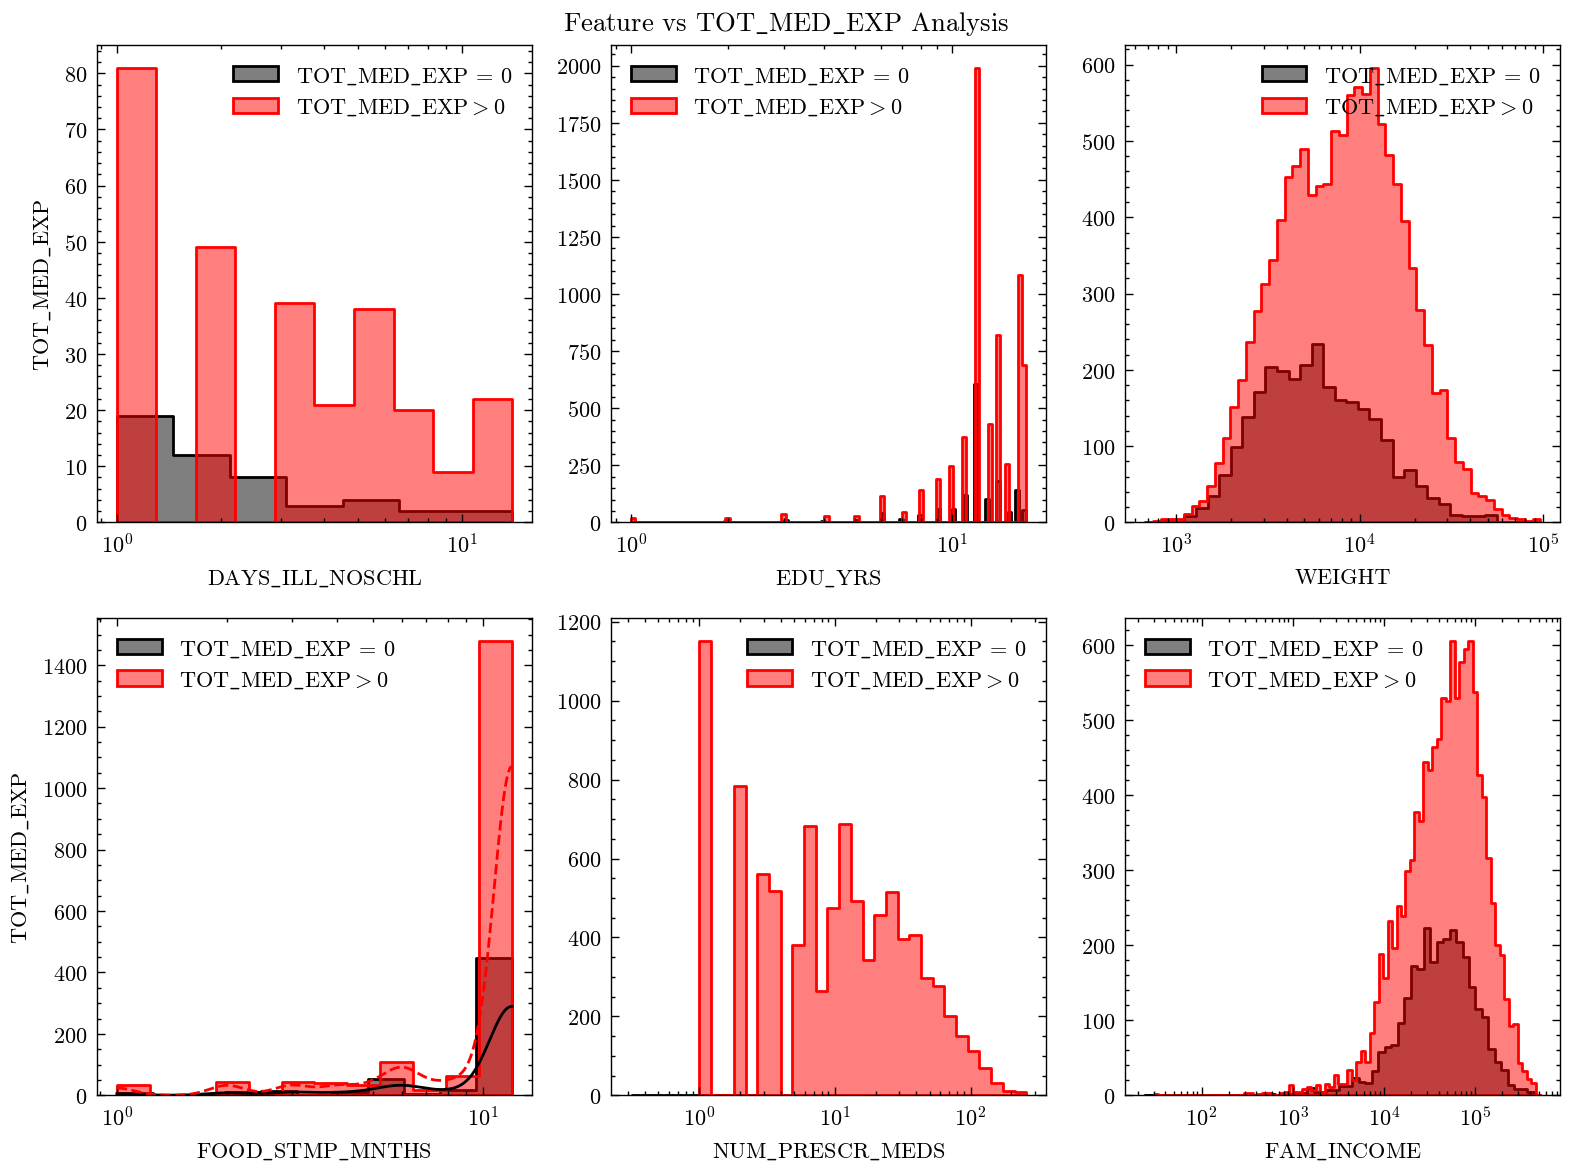

In [28]:
if not NO_PLOTS:
    plots.plot_features_vs_target(
        df_train_y_is_0,
        REG_TARGET,
        features=numerical_cols,
        style=PAPER_STYLE,
        n_features=6,
        max_rows=2,
        is_categorical=True,
        categorical_legend={1: "TOT_MED_EXP = 0", 0: r"TOT_MED_EXP$>$0"},
        x_log_scale=True,
    )

In [2]:
if RUN_REG_Y_IS_0:
    pipeline = experiments.preprocessing_pipeline(columns_to_drop=correlated_cols + low_variance_cols)
    pipeline = experiments.extend_pipeline(
        pipeline,
        ("remove_constant", VarianceThreshold(threshold=0)),
        ("dimensionality_reduction", None),
        ("poly_features", PolynomialColumnTransformer(n_dimensions=5, degree=3, include_bias=True)),
        ("select", SelectKBest()),
        ("nystroem", FunctionTransformer()),  # For kernel approximation (LinearSVC, NuSVC)
        ("classifier", None),
    )

    # Define the parameter grid
    base_param_grid = {
        "preprocessing__numerical__scaler": [RobustScaler()],
        "select__k": [2, 10, 80],
        "select__score_func": [f_classif], # chi2, mutual_info_classif],
        # Dimensionality reduction techniques
        "dimensionality_reduction": [
            PCA(random_state=RANDOM_STATE),
            FastICA(random_state=RANDOM_STATE, whiten="unit-variance", whiten_solver="svd"),
            LinearDiscriminantAnalysis(),
        ],
        "dimensionality_reduction__n_components": [2, 10, 80, None],
        # Classifiers
        "classifier": [
            GaussianNB(),
            LogisticRegression(),
            KNeighborsClassifier(),
            LinearDiscriminantAnalysis(),
            QuadraticDiscriminantAnalysis(),
            RidgeClassifier(),
            PassiveAggressiveClassifier(),
            MBSGDClassifier() if USE_CUML else SGDClassifier(),
            LinearSVC(),
            NuSVC(),
        ],
        "nystroem": [Nystroem()],
        "nystroem__n_components": [2, 10, 80, 100],
        "nystroem__kernel": ['rbf', 'poly', 'sigmoid'],
    }

    # Make a list of param grids by combining the preprocessing and classifier hyperparameters
    param_grids = construct_param_grids_list(base_param_grid, key="classifier")

    # Iterate over each classifier
    tuning.run_model_search(
        X_is_0_clf_train,
        y_is_0_clf_train,
        X_is_0_clf_test,
        y_is_0_clf_test,
        param_grids,
        pipeline,
        task_type="classification",
        output_dir=CLF_IS_0_DIR,
        use_cuml=USE_CUML,
        subset=1
    )

NameError: name 'experiments' is not defined

In [30]:
if RUN_REG_Y_IS_0:
    summary_df = tuning.plot_runs(
        CLF_IS_0_DIR,
        ["recall"],
        summary_table=True,
        figsize=(6, 3),
        title="Model Performance Comparison",
        style=PAPER_STYLE,
        save_path=os.path.join(CLF_IS_0_DIR, "performance_comparison"),
        save_format="pdf",
        xtick_rotation=30,
        grid=True
    )

In [32]:
if RUN_REG_Y_IS_0:
    helpers.pivot_df_to_multiindex(
        summary_df, "model", "set", ["recall"], sort_by="recall", sort_row="val", ascending=False
    )

**Now, we can show the results of the best classifier of `y = 0` and `y > 0`.**

The best classifier is: SGDClassifier
2024-08-19 22:11:43,222 - root - WARNING - Likely categorical columns detected: ['TOT_MED_EXP']. These columns are not necessarily of object dtype.


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:414: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


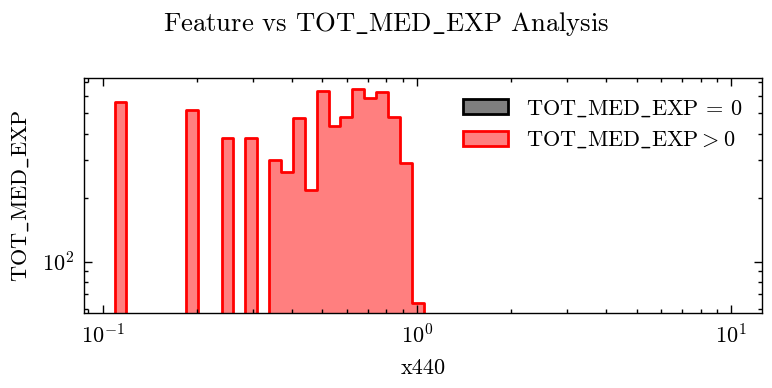

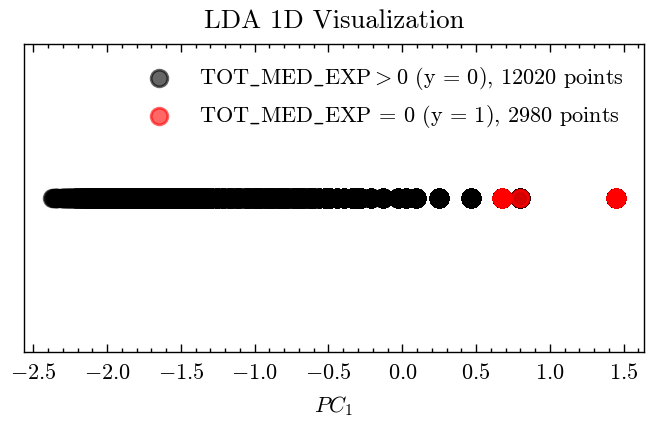

In [35]:
best_classifier, best_classifier_name, _ = tuning.find_best_model(CLF_IS_0_DIR, "recall")
print(f"The best classifier is: {best_classifier_name}")

X_is_0_clf_transformed = best_classifier[:-1].transform(X_is_0_clf)
X_is_0_clf_transformed[REG_TARGET] = y_is_0_clf

plots.plot_features_vs_target(
    X_is_0_clf_transformed,
    REG_TARGET,
    style=PAPER_STYLE,
    n_features=3,
    is_categorical=True,
    categorical_legend={1: "TOT_MED_EXP = 0", 0: r"TOT_MED_EXP$>$0"},
    figsize=(4, 2),
    x_log_scale=True,
    y_log_scale=True,
)

plots.visualize(
    X_is_0_clf_transformed.drop(columns=[REG_TARGET]),
    n_components=1,
    method="lda",
    indices=[y_is_0_clf == 0, y_is_0_clf == 1],
    labels=[
        f"TOT_MED_EXP$>$0 (y = 0), {neg_samples} points",
        f"TOT_MED_EXP = 0 (y = 1), {pos_samples} points",
    ],
    style=PAPER_STYLE,
    figsize=(4, 2),
)

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:758: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


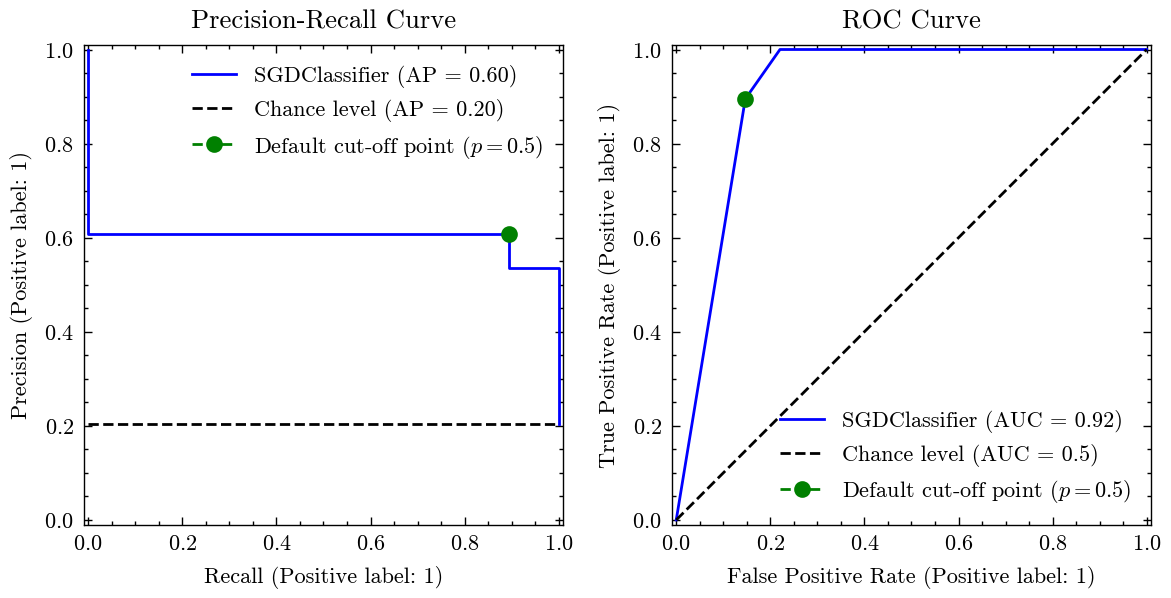

In [36]:
plots.plot_pr_roc_curves(
    best_classifier,
    X_is_0_clf_test,
    y_is_0_clf_test,
    clf_name=best_classifier_name,
    style=PAPER_STYLE,
)

In [37]:
y_is_0_clf_pred = best_classifier.predict(X_is_0_clf_test)

print(skm.classification_report(y_is_0_clf_test, y_is_0_clf_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      2390
           1       0.61      0.90      0.72       610

    accuracy                           0.86      3000
   macro avg       0.79      0.87      0.82      3000
weighted avg       0.90      0.86      0.87      3000



In [38]:
print(
    f"Business defined metric: {scorers.clf_scorers['cost_gain'](best_classifier, X_is_0_clf_test, y_is_0_clf_test)}"
)

from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=best_classifier,
    scoring=scorers.clf_scorers["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_is_0_clf_train, y_is_0_clf_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

Business defined metric: -671


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 12 14 16 17 19 27 29 31 32 34 37 39 40 41 42 44 45 47 48 49 50 51 53
 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 12 13 14 16 17 19 27 28 29 31 32 34 37 38 39 40 41 42 43 44 45 47 48
 49 50 51 53 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 12 14 16 17 27 29 31 32 37 39 40 41 42 44 45 47 48 49 50 51] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/camilo/Repositorios/venvs/gpu/lib/python3.11

tuned_model.best_threshold_=-10.00


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 12 14 16 17 19 27 29 31 32 34 37 39 40 41 42 44 45 47 48 49 50 51 53
 54] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


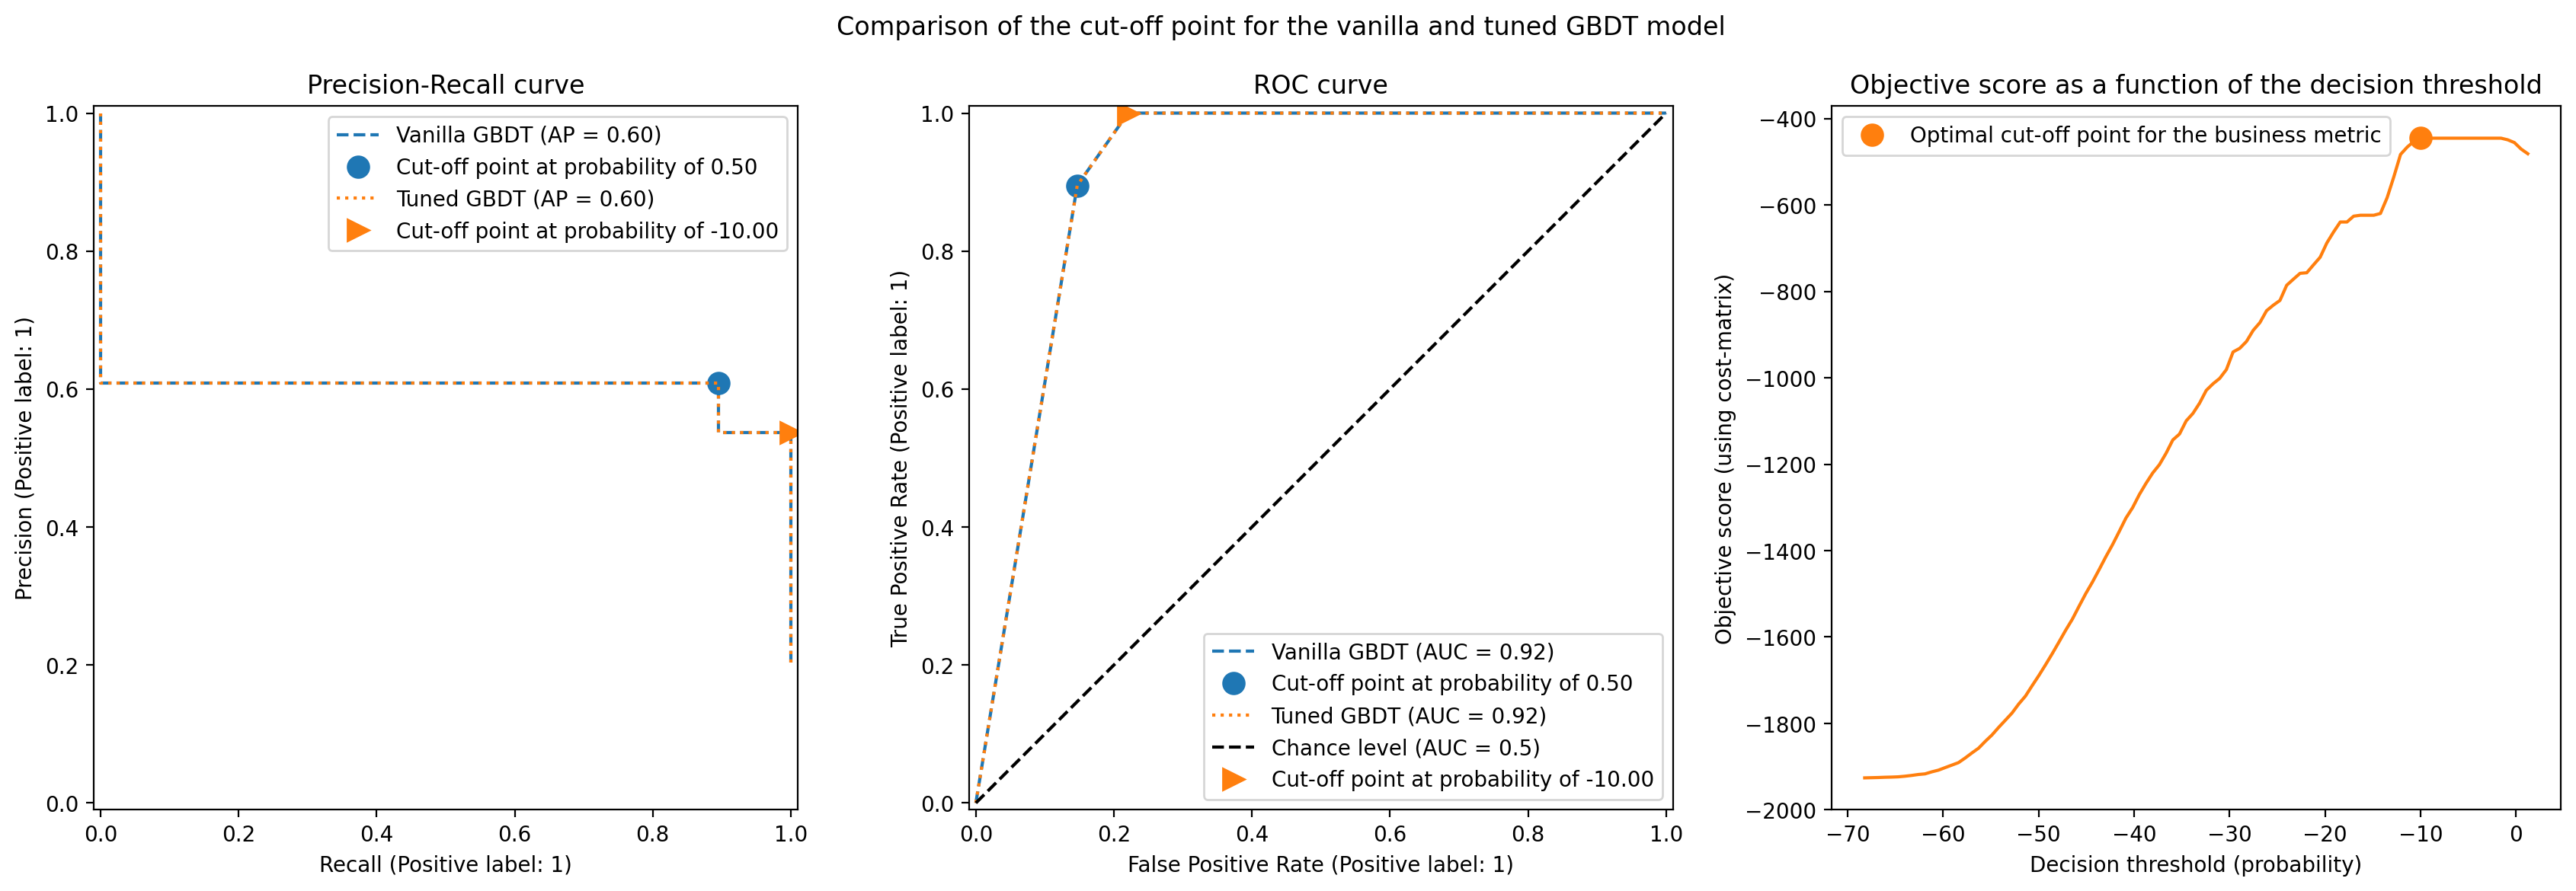

Business defined metric: -527


In [39]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay


def plot_roc_pr_curves(vanilla_model, tuned_model, X_test, y_test, *, title, pos_label=1):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla GBDT", "Tuned GBDT")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scorers.clf_scorers["recall"](est, X_test, y_test),
            scorers.clf_scorers["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scorers.clf_scorers["fpr"](est, X_test, y_test),
            scorers.clf_scorers["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

    plt.show()
    plt.close(fig)


title = "Comparison of the cut-off point for the vanilla and tuned GBDT model"
plot_roc_pr_curves(best_classifier, tuned_model, X_is_0_clf_test, y_is_0_clf_test, title=title)
print(
    f"Business defined metric: {scorers.clf_scorers['cost_gain'](tuned_model, X_is_0_clf_test, y_is_0_clf_test)}"
)

In [40]:
y_is_0_clf_pred = tuned_model.predict(X_is_0_clf_train)

print(skm.classification_report(y_is_0_clf_train, y_is_0_clf_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9630
           1       0.52      1.00      0.68      2370

    accuracy                           0.82     12000
   macro avg       0.76      0.88      0.78     12000
weighted avg       0.90      0.82      0.83     12000



In [41]:
y_is_0_clf_pred = tuned_model.predict(X_is_0_clf_test)

print(skm.classification_report(y_is_0_clf_test, y_is_0_clf_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      2390
           1       0.54      1.00      0.70       610

    accuracy                           0.82      3000
   macro avg       0.77      0.89      0.79      3000
weighted avg       0.91      0.82      0.84      3000



### Train a linear regression model for `y > 0`
Now, the regressor will predict the target value for the samples where the target value is greater than zero.

In [43]:
# outliers = st.detect_outliers(df_train_mirror, column_name=REG_TARGET, method="modified-z-score")
# outliers = st.detect_outliers(
#     df_train_mirror,
#     column_name=REG_TARGET,
#     method="iqr",
#     iqr_lower_percentile=1,
#     iqr_upper_percentile=99,
# )
outliers = st.detect_outliers(df_train_mirror, column_name=REG_TARGET, method="isolation-forest")
print(f"Found {outliers.sum()} outliers of {df_train.shape[0]} samples")

# Drop the outliers
df_train = df_train[~outliers]
df_train_mirror = df_train_mirror[~outliers]
print(f"Number of samples after dropping outliers: {df_train_mirror.shape[0]}")

Found 624 outliers of 15000 samples
Number of samples after dropping outliers: 14376


In [44]:
# Drop rows with y == 0
df_train_y_ge_0 = df_train.copy()
df_train_y_ge_0 = df_train_y_ge_0[df_train_y_ge_0[REG_TARGET] > 0]

X_ge_0_reg = df_train_y_ge_0.drop(columns=[REG_TARGET])
y_ge_0_reg = df_train_y_ge_0[REG_TARGET]

# Split X and y for training and validation purposes
X_ge_0_reg_train, X_ge_0_reg_test, y_ge_0_reg_train, y_ge_0_reg_test = (
    helpers.make_train_test_split(
        X_ge_0_reg, y_ge_0_reg, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
)

Training shape: (9188, 412)
Testing shape: (2298, 412)


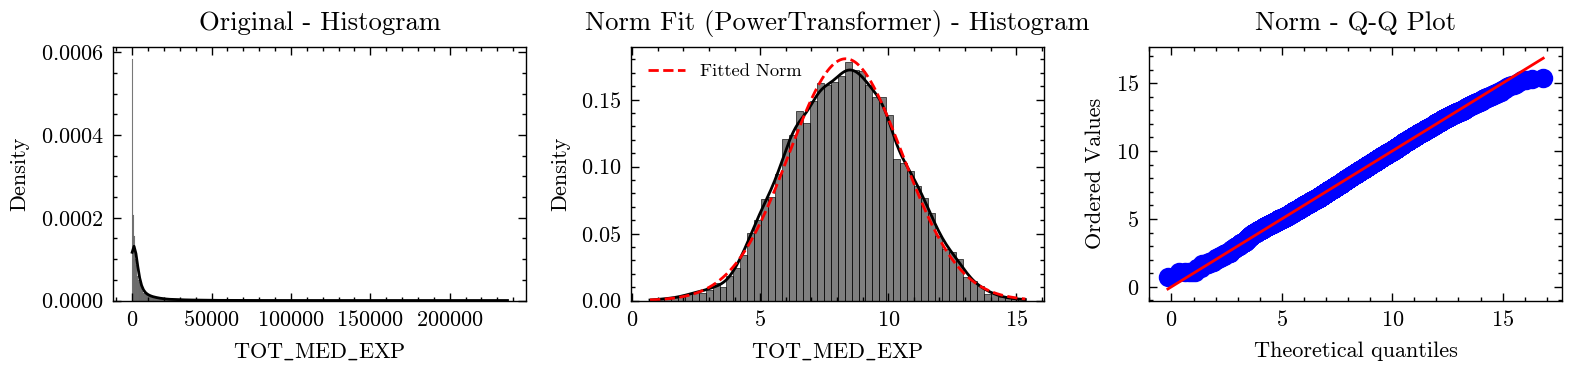

Fitted Norm distribution parameters: (8.339569526065022, 2.2109391630162083)
Original data summary:
	Minimum: 1.0000
	Maximum: 236449.0000
	Mean: 5499.0172
	Standard Deviation: 12476.3726
	Number of Zeros: 0
Transformed data summary:
	Minimum: 0.7013
	Maximum: 15.3558
	Mean: 8.3396
	Standard Deviation: 2.2109
	Number of Zeros: 0


In [45]:
st.plot_distribution_fits(
    df_train_y_ge_0,
    REG_TARGET,
    apply_transform=PowerTransformer(method="yeo-johnson", standardize=False),
    show_original_histogram=True,
    hist_legend_pos="upper left",
    style=PAPER_STYLE,
)

In [ ]:
pipeline = experiments.preprocessing_pipeline(drop_columns=correlated_cols + low_variance_cols)
pipeline = experiments.extend_pipeline(
    pipeline,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("dimensionality_reduction", None),
    ("select", SelectKBest(score_func=f_regression)),
    ("nystroem", FunctionTransformer()),  # For kernel approximation (LinearSVR, NuSVR)
    (
        "regressor",
        TransformedTargetRegressor(
            regressor=SGDRegressor(),
            transformer=PowerTransformer(method="yeo-johnson", standardize=False),
        ),
    ),
)

# Define the parameter grid
base_param_grid = {
    "preprocessing__numerical__scaler": [RobustScaler()],
    "select__k": [2, 10, 80],
    "select__score_func": [f_regression],
    # Dimensionality reduction techniques
    "dimensionality_reduction": [
        PCA(random_state=RANDOM_STATE),
        FastICA(random_state=RANDOM_STATE, whiten="unit-variance", whiten_solver="svd"),
        LinearDiscriminantAnalysis(),
    ],
    "dimensionality_reduction__n_components": [2, 10, 80, None],
    # Classifiers
    "regressor__regressor": [
        Lasso(),
        LassoLars(),
        Ridge(),
        LinearRegression(),
        TweedieRegressor(),
        KernelRidge(),
        PassiveAggressiveRegressor(),
        SGDRegressor(),
        LinearSVR(),
        NuSVR(),
    ],
    "nystroem": [Nystroem()],
    "nystroem__n_components": [2, 10, 80, 100],
    "nystroem__kernel": ["rbf", "poly", "sigmoid"],
}

# Make a list of param grids by combining the preprocessing and classifier hyperparameters
param_grids = construct_param_grids_list(base_param_grid, key="regressor__regressor")

tuning.run_model_search(
    X_ge_0_reg_train,
    y_ge_0_reg_train,
    X_ge_0_reg_test,
    y_ge_0_reg_test,
    param_grids,
    pipeline,
    task_type="regression",
    output_dir=REG_GE_0_DIR,
    use_cuml=USE_CUML,
    subset=1
)

NameError: name 'X_ge_0_reg_train' is not defined

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:272: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


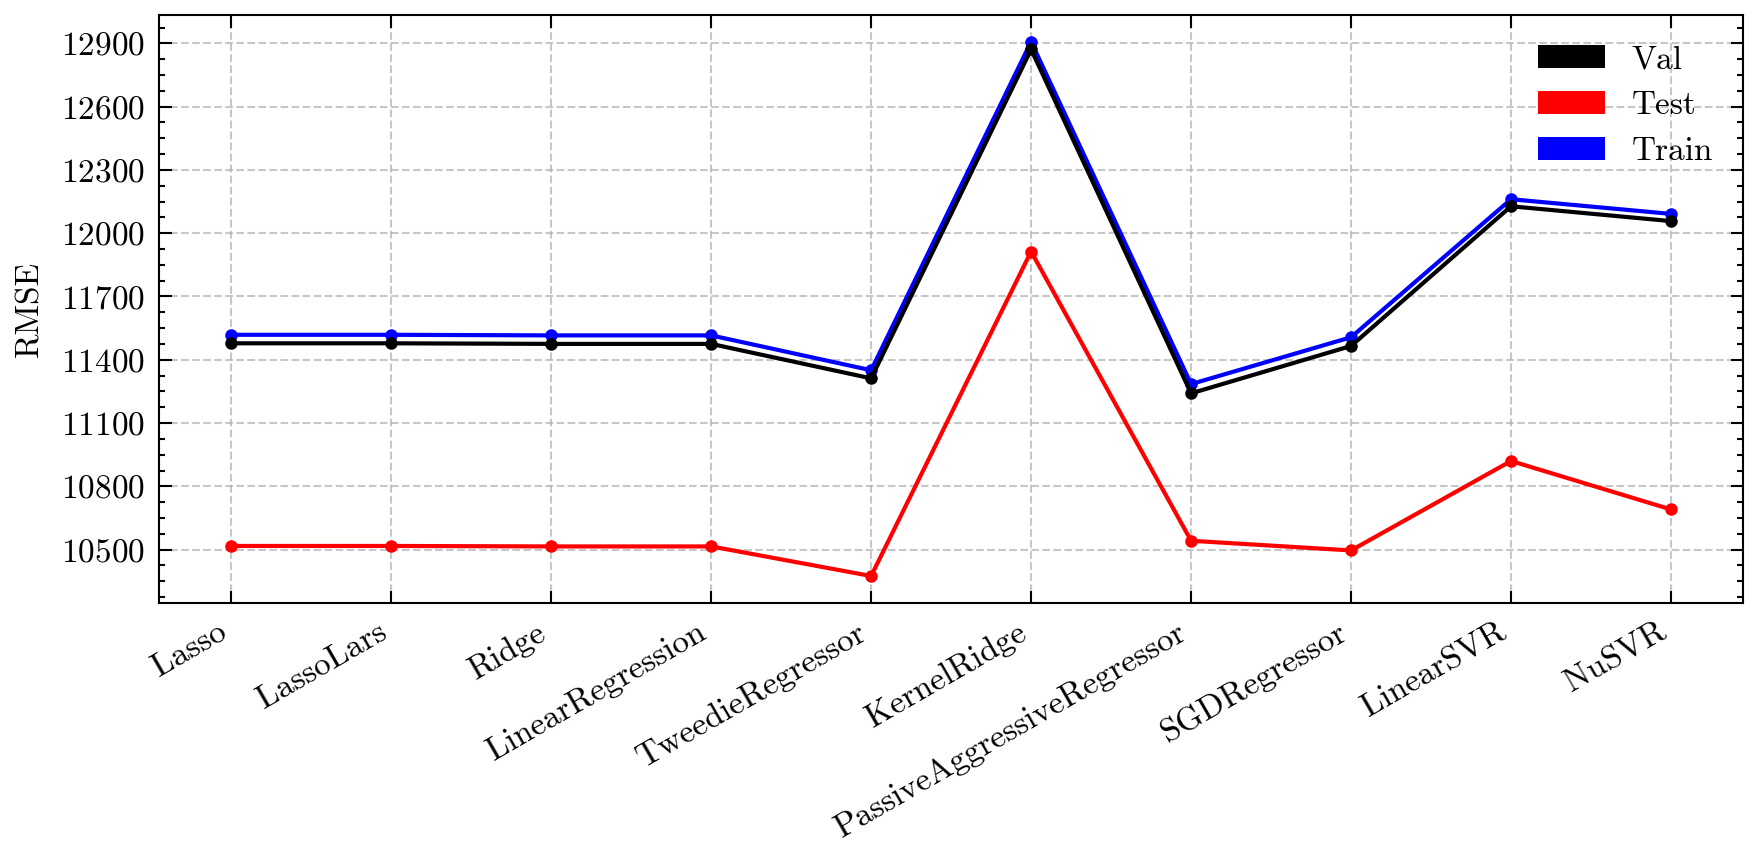

In [ ]:
if RUN_REG_Y_GE_0:
    tuning.plot_runs(
        REG_GE_0_DIR,
        ["RMSE"],
        figsize=(6, 3),
        title="Model Performance Comparison",
        style=PAPER_STYLE,
        save_path=os.path.join(REG_GE_0_DIR, "reg_performance_comparison"),
        save_format="pdf",
        xtick_rotation=30,
        grid=True
    )

In [46]:
best_regressor = experiments.preprocessing_pipeline(drop_columns=correlated_cols + low_variance_cols)
best_regressor = experiments.extend_pipeline(
    best_regressor,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("select", SelectKBest(score_func=f_regression)),
    (
        "regressor",
        TransformedTargetRegressor(
            regressor=LinearRegression(),
            transformer=PowerTransformer(method="yeo-johnson", standardize=False),
        ),
    ),
)

best_regressor.fit(X_ge_0_reg_train, y_ge_0_reg_train)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('column_dropper',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dropper', 'drop',
                                                  ['SCHOOL_LIM', 'PROB_WBHV',
                                                   'ADV_EAT_HLTHY',
                                                   'POVRTY_LEV', 'UNION_STAT',
                                                   'UNABL_PRES_MED',
                                                   'ADV_BOOST_SEAT',
                                                   'WHEN_ADV_BOOST_SEAT'])])),
                ('preprocessing',
                 FeatureUnion(transformer_list=[('categorical',
                                                 Pipeline(steps=[('feature_set_decider',
                                                                  FeatureSetD...
                                                                                                  Pipeline(steps=[('feature_set_decider',
                                                                                                                   FeatureSetDecider(mode='skewed')),
                                                                                                                  ('power_transformer',
                                                                                                                   PowerTransformer())]))])),
                                                                 ('scaler',
                                                                  None)]))])),
                ('remove_constant', VarianceThreshold(threshold=0)),
                ('select',
                 SelectKBest(score_func=<function f_regression at 0x7fe183a4e520>)),
                ('regressor',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=PowerTransformer(standardize=False)))])

Number of 0s in the true target variable:  2370
Number of 0s in the predicted target variable:  4585


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:661: UserWarning: The figure layout has changed to tight
  f.tight_layout()


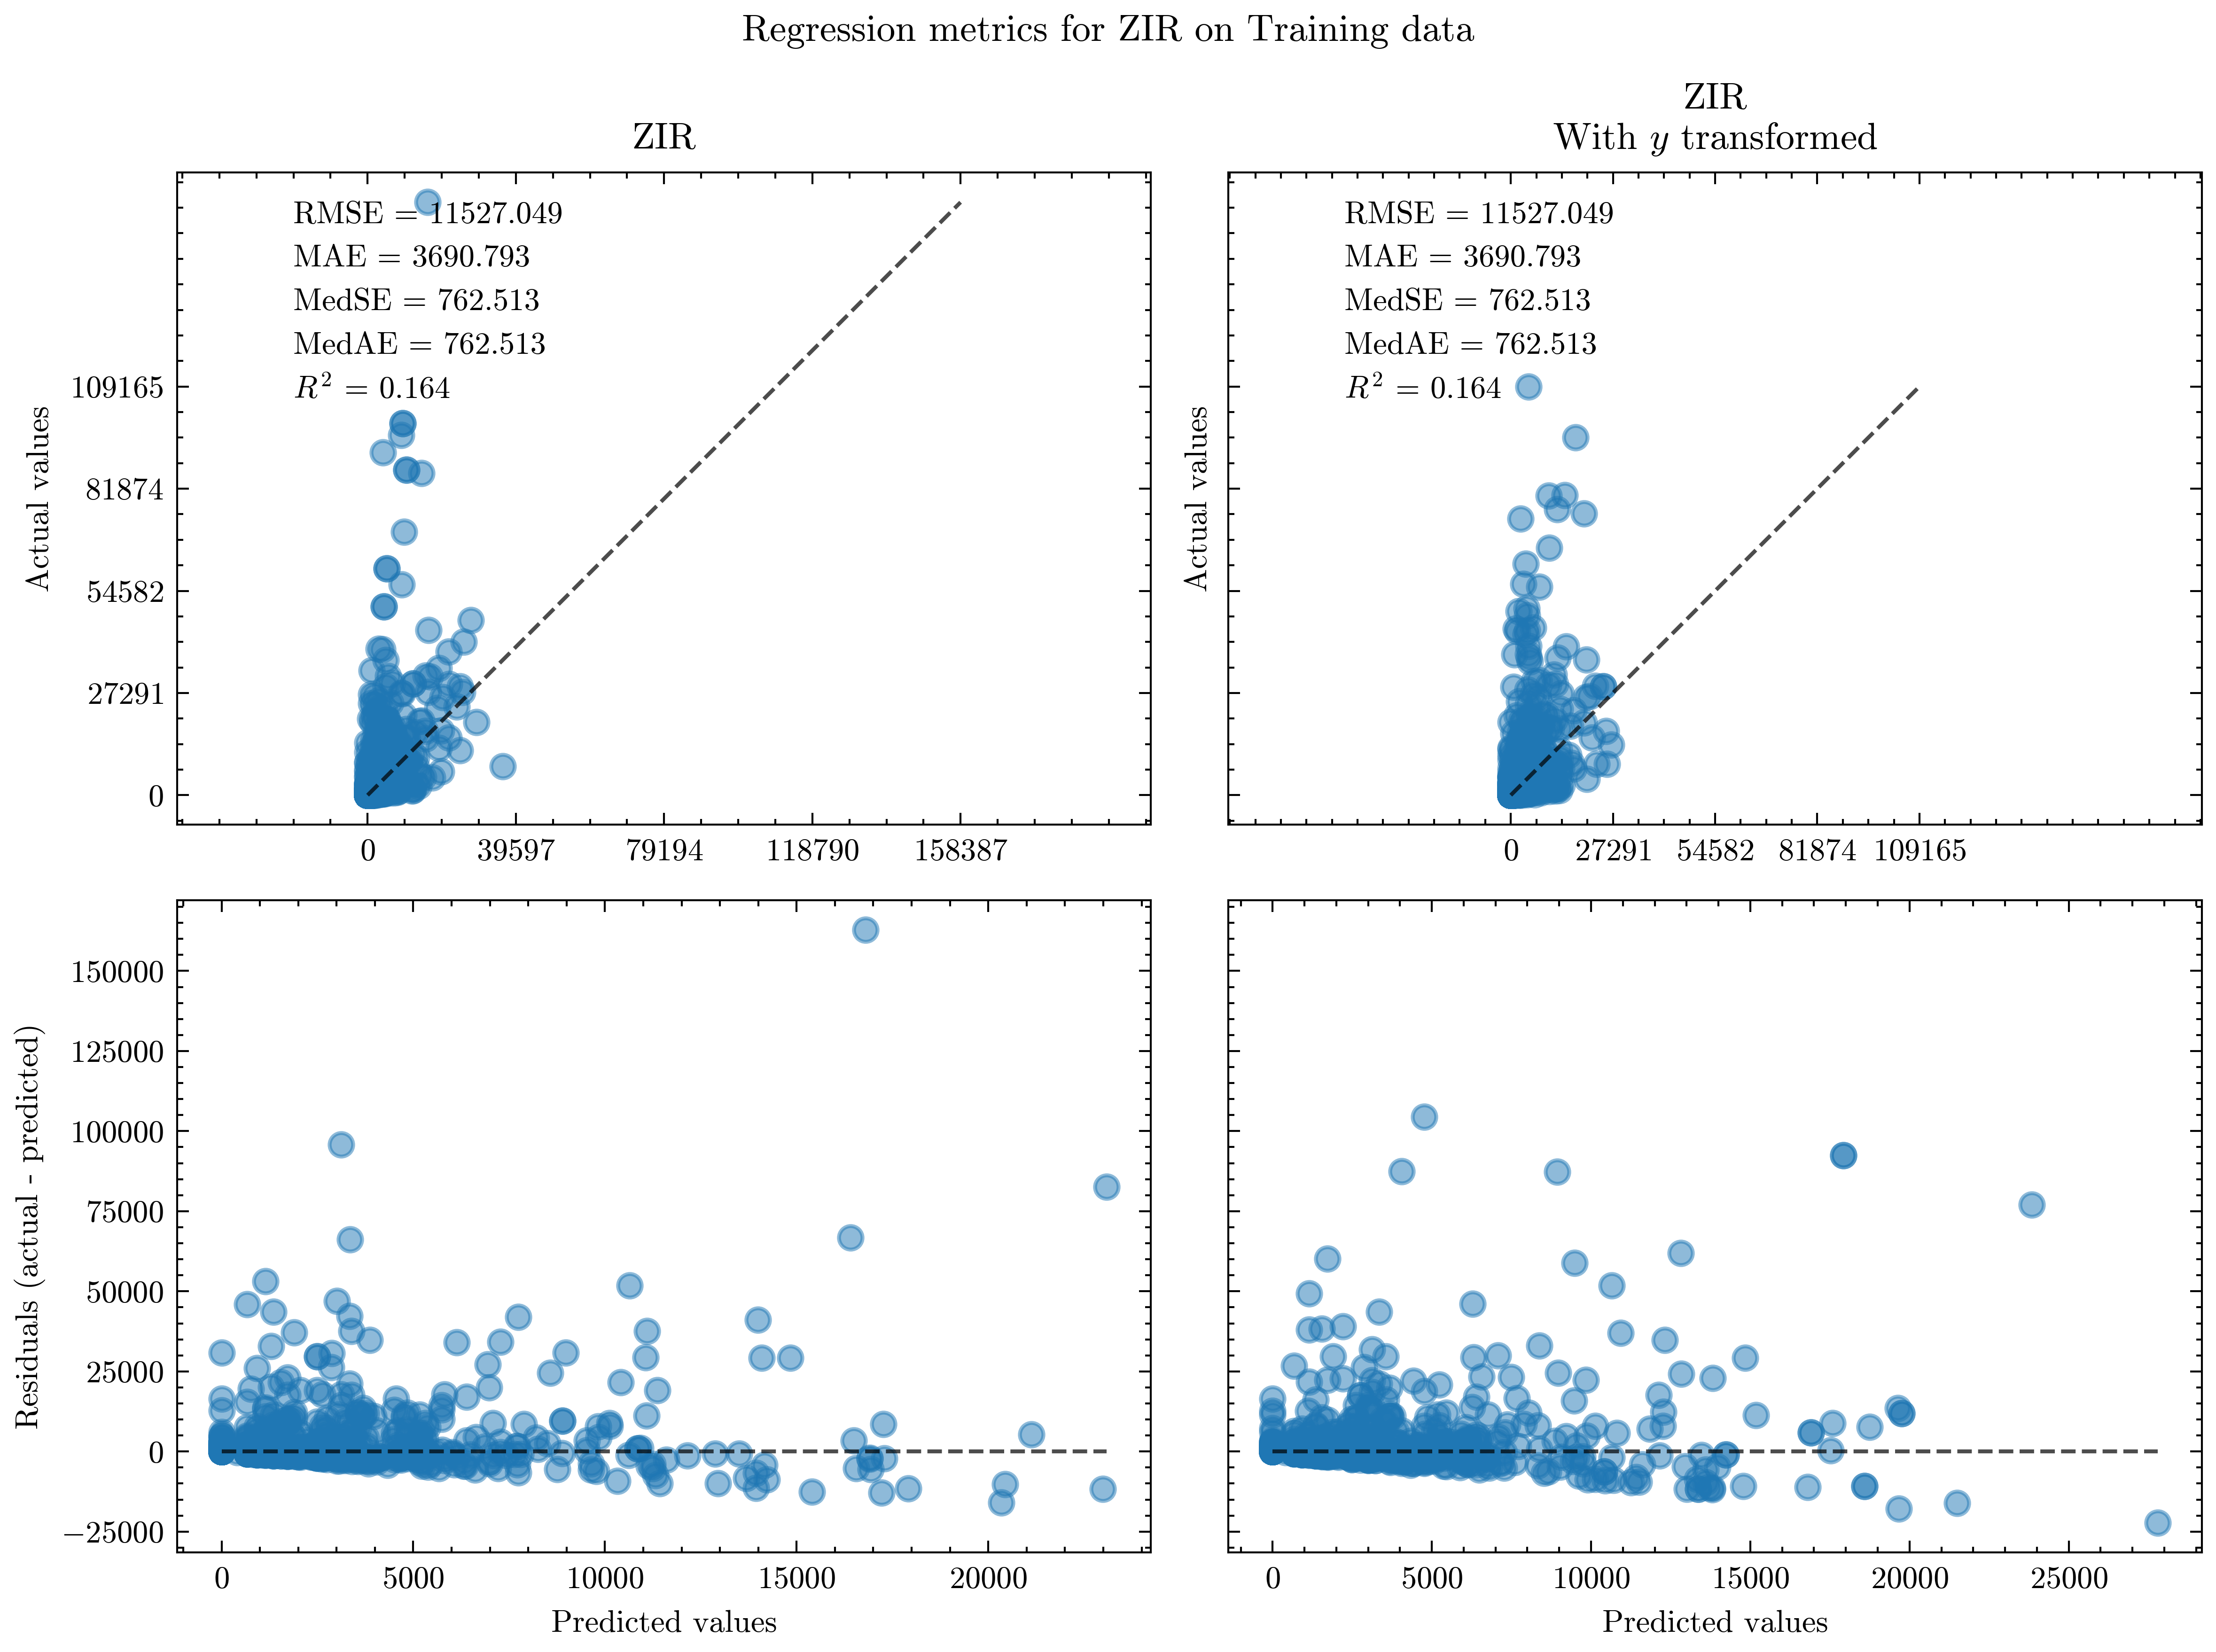

Classification performance on Training data (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0):
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2370
           1       1.00      0.77      0.87      9630

    accuracy                           0.82     12000
   macro avg       0.76      0.88      0.78     12000
weighted avg       0.90      0.82      0.83     12000

Classification performance (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0) (y-transformed):
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2370
           1       1.00      0.77      0.87      9630

    accuracy                           0.82     12000
   macro avg       0.76      0.88      0.78     12000
weighted avg       0.90      0.82      0.83     12000

Number of 0s in the true target variable:  610
Number of 0s in the predicted target variable:  1137


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:661: UserWarning: The figure layout has changed to tight
  f.tight_layout()


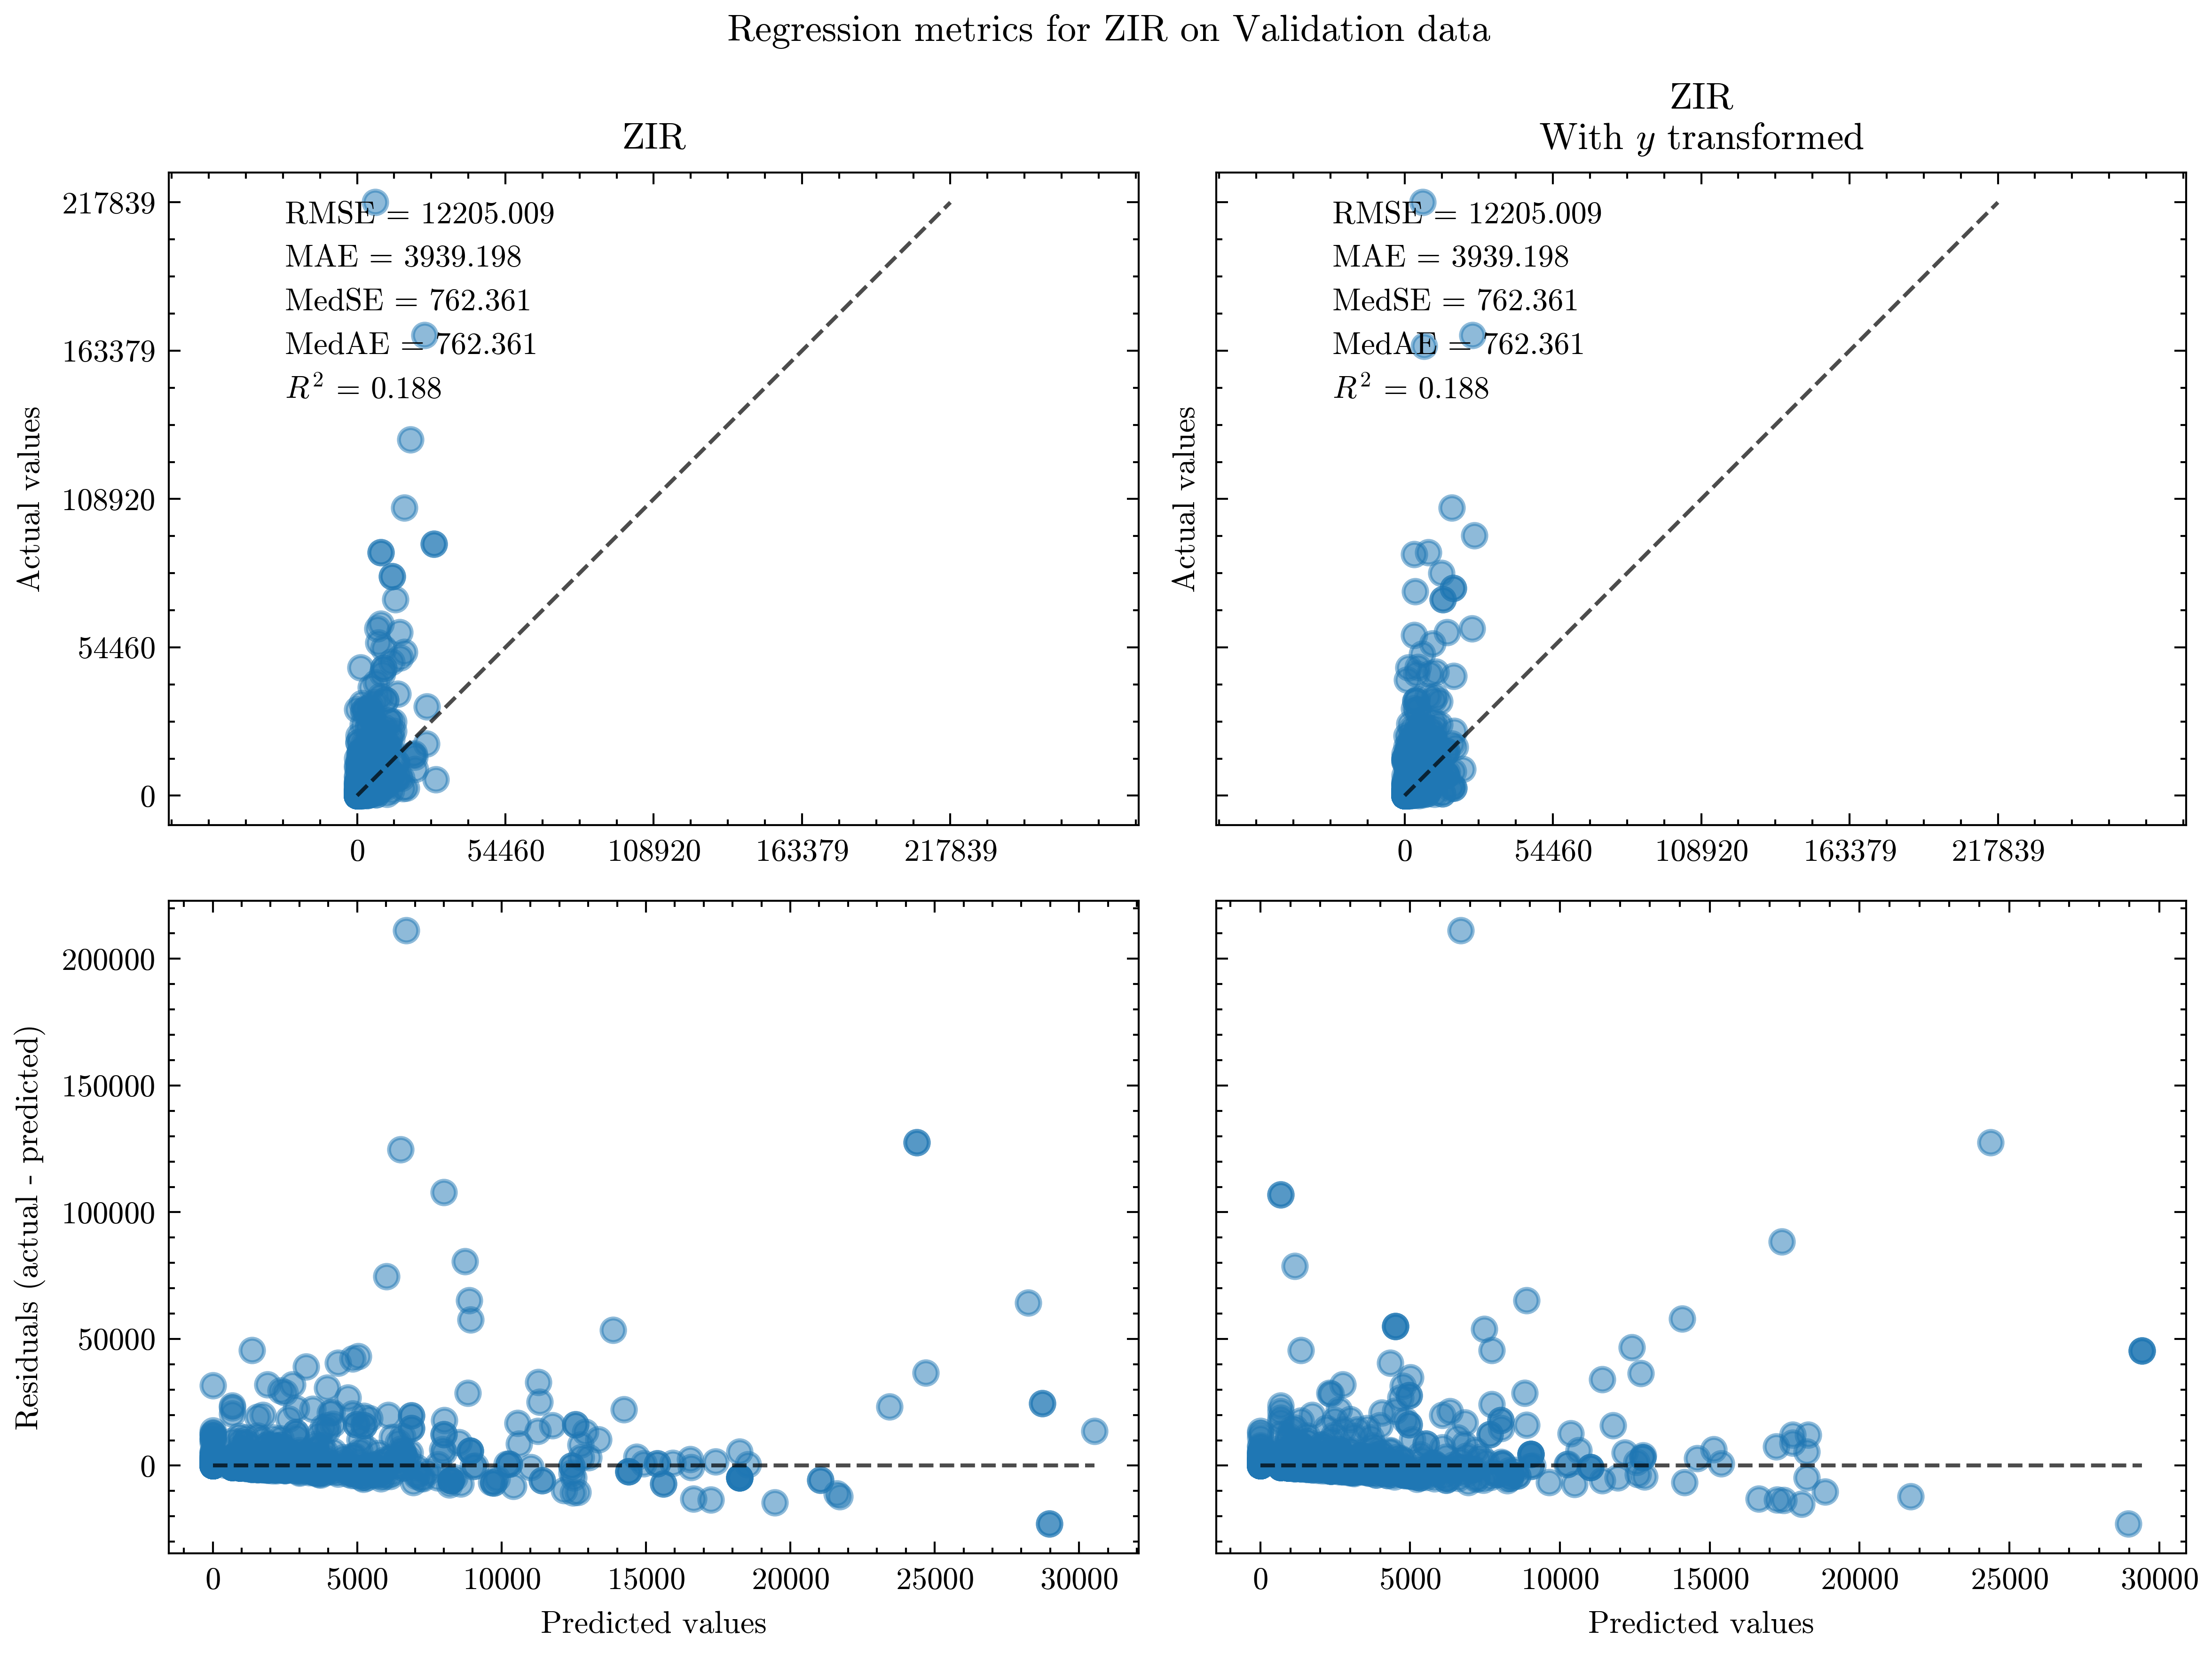

Classification performance on Validation data (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0):
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       610
           1       1.00      0.78      0.88      2390

    accuracy                           0.82      3000
   macro avg       0.77      0.89      0.79      3000
weighted avg       0.91      0.82      0.84      3000

Classification performance (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0) (y-transformed):
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       610
           1       1.00      0.78      0.88      2390

    accuracy                           0.82      3000
   macro avg       0.77      0.89      0.79      3000
weighted avg       0.91      0.82      0.84      3000

+---------------------------------------------------------------------+
|                          Regression metrics                         |
+----------

In [60]:
# Modify pipeline for target transformation
from models.model import FittedZeroInflatedRegressor


best_zir = FittedZeroInflatedRegressor(regressor=best_regressor, classifier=tuned_model)

regressor_name = "ZIR"

datasets = {
    "Training data": [X_train_reg, y_train_reg],
    "Validation data": [X_test_reg, y_test_reg],
}

rows = []  # For a PrettyTable
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_zir.predict(X_i)
    y_pred_transformed = best_zir.predict(X_i)

    # If y == 0, then the model must predict 0, otherwise something different than 0
    y_i_clf = (y_i != 0).astype(int)
    y_pred_clf = (y_pred != 0).astype(int)
    y_pred_transformed_clf = (y_pred_transformed != 0).astype(int)

    print("Number of 0s in the true target variable: ", (y_i == 0).sum())
    print("Number of 0s in the predicted target variable: ", (y_pred == 0).sum())
    
    # Compute the regression metrics
    rmse, mae, medse, medae, r2 = my_metrics.compute_scores(y_i, y_pred)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        my_metrics.compute_scores(y_i, y_pred_transformed)
    )

    # Round them to 3 decimal places
    rmse, mae, medse, medae, r2 = helpers.round_values(rmse, mae, medse, medae, r2)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        helpers.round_values(
            rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed
        )
    )

    metrics = [
        {
            "RMSE": rmse,
            "MAE": mae,
            "MedSE": medse,
            "MedAE": medae,
            "$R^2$": r2,
        },
        {
            "RMSE": rmse_transformed,
            "MAE": mae_transformed,
            "MedSE": medse_transformed,
            "MedAE": medae_transformed,
            "$R^2$": r2_transformed,
        },
    ]

    plots.regression_performance_comparison(
        y_i,
        y_pred,
        y_pred_transformed,
        metrics=metrics,
        suptitle=f"Regression metrics for {regressor_name} on {split_name.capitalize()}",
        regressor_name=regressor_name,
        style=PAPER_STYLE,
    )

    rows.append([split_name, rmse, mae, medse, medae, r2])
    rows.append(
        [
            " (y-transformed)",
            rmse_transformed,
            mae_transformed,
            medse_transformed,
            medae_transformed,
            r2_transformed,
        ]
    )

    print(
        f"Classification performance on {split_name} (question: Should {REG_TARGET} = 0? Yes: 1, No: 0):"
    )
    print(skm.classification_report(y_i_clf, y_pred_clf, zero_division=0))

    print(
        f"Classification performance (question: Should {REG_TARGET} = 0? Yes: 1, No: 0) (y-transformed):"
    )
    print(skm.classification_report(y_i_clf, y_pred_transformed_clf))

print(
    helpers.make_pretty_table(
        rows,
        title="Regression metrics",
        field_names=["Split", "RMSE", "MAE", "MedSE", "MedAE", "R^2"],
        alignments=["l"],
    )
)

### Train a linear regression model

In [ ]:
pipeline = experiments.preprocessing_pipeline(drop_columns=correlated_cols + low_variance_cols)
pipeline = experiments.extend_pipeline(
    pipeline,
    ("remove_constant", VarianceThreshold(threshold=0)),
    (
        "zir",
        ZeroInflatedRegressor(
            regressor=Pipeline(
                steps=[
                    ("select", SelectKBest(score_func=f_regression)),
                    ("regressor", SGDRegressor()),
                ]
            ),
            classifier=Pipeline(
                steps=[
                    ("select", SelectKBest(score_func=f_classif)),
                    ("classifier", SGDClassifier()),
                ]
            ),
        ),
    ),
)

# Regressor parameter grid
regressor_param_grid = choose_param_grid(
    pipeline.named_steps["zir"].regressor.named_steps["regressor"],
    add_str_to_keys="zir__regressor__regressor",
)
regressor_param_grid["preprocessing__numerical__scaler"] = [RobustScaler(), StandardScaler()]
regressor_param_grid["zir__regressor__select__k"] = [2, 10, 80]
regressor_param_grid["zir__classifier__select__k"] = [2, 10, 80]

# Classifier parameter grid
clf_param_grid = choose_param_grid(
    pipeline.named_steps["zir"].classifier.named_steps["classifier"],
    add_str_to_keys="zir__classifier__classifier",
)

# Make the final param grid
param_grid = combine_param_grids(regressor_param_grid, clf_param_grid)
param_grid = make_smaller_param_grid(param_grid, subset=2)

print(f"Using the following hyperparameter grid for {pipeline.named_steps['zir']}:")
print(helpers.describe_param_grid(param_grid, tabs=1))
print()

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    error_score="raise",
    verbose=10,
)

grid_search.fit(X_train_reg, y_train_reg)

best_estimator = grid_search.best_estimator_

print("Best hyperparameters found: ", grid_search.best_params_)

### Train a model with a `y` transformed

See: https://scikit-learn.org/dev/auto_examples/compose/plot_transformed_target.html

In [ ]:
st.plot_distribution_fits(
    df_train,
    REG_TARGET,
    apply_transform=PowerTransformer(method="yeo-johnson", standardize=False),
    show_original_histogram=True,
    style=PAPER_STYLE
)

In [ ]:
# Modify pipeline for target transformation
pipeline_y_transformed = experiments.preprocessing_pipeline(
    drop_columns=correlated_cols + low_variance_cols
)
pipeline_y_transformed = experiments.extend_pipeline(
    pipeline_y_transformed,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("final_scale", None),
    (
        "zir_trans",
        TransformedTargetRegressor(
            regressor=ZeroInflatedRegressor(
                regressor=Pipeline(
                    steps=[
                        ("select", SelectKBest(score_func=f_regression)),
                        ("regressor", SGDRegressor()),
                    ]
                ),
                classifier=Pipeline(
                    steps=[
                        ("select", SelectKBest(score_func=f_classif)),
                        ("classifier", SGDClassifier()),
                    ]
                ),
            ),
            transformer=PowerTransformer(method="yeo-johnson", standardize=False),
        ),
    ),
)

# Regressor parameter grid
regressor_param_grid = choose_param_grid(
    pipeline_y_transformed.named_steps["zir_trans"].regressor.regressor.named_steps["regressor"],
    add_str_to_keys="zir_trans__regressor__regressor__regressor",
)
regressor_param_grid["preprocessing__numerical__scaler"] = [RobustScaler(), StandardScaler()]
regressor_param_grid["final_scale"] = [RobustScaler(), StandardScaler()]
regressor_param_grid["zir_trans__regressor__regressor__select__k"] = [2, 10, 80]
regressor_param_grid["zir_trans__regressor__classifier__select__k"] = [2, 10, 80]

# Classifier parameter grid
clf_param_grid = choose_param_grid(
    pipeline_y_transformed.named_steps["zir_trans"].regressor.classifier.named_steps["classifier"],
    add_str_to_keys="zir_trans__regressor__classifier__classifier",
)

# Make the final param grid
param_grid = combine_param_grids(regressor_param_grid, clf_param_grid)
param_grid = make_smaller_param_grid(param_grid, subset=1)

print(
    f"Using the following hyperparameter grid for {pipeline_y_transformed.named_steps['zir_trans']}:"
)
print(helpers.describe_param_grid(param_grid, tabs=1))
print()

grid_search = GridSearchCV(
    pipeline_y_transformed,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best estimator
best_estimator_y_transformed = grid_search.best_estimator_

### Evaluate the linear regression model

In [ ]:
regressor_name = best_estimator.named_steps["zir"].__class__.__name__

datasets = {
    "Training data": [X_train_reg, y_train_reg],
    "Validation data": [X_test_reg, y_test_reg],
}

rows = []  # For a PrettyTable
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_estimator.predict(X_i)
    y_pred_transformed = best_estimator_y_transformed.predict(X_i)

    # If y == 0, then the model must predict 0, otherwise something different than 0
    y_i_clf = (y_i != 0).astype(int)
    y_pred_clf = (y_pred != 0).astype(int)
    y_pred_transformed_clf = (y_pred_transformed != 0).astype(int)

    # Compute the regression metrics
    rmse, mae, medse, medae, r2 = my_metrics.compute_scores(y_i, y_pred)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        my_metrics.compute_scores(y_i, y_pred_transformed)
    )

    # Round them to 3 decimal places
    rmse, mae, medse, medae, r2 = helpers.round_values(rmse, mae, medse, medae, r2)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        helpers.round_values(
            rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed
        )
    )

    metrics = [
        {
            "RMSE": rmse,
            "MAE": mae,
            "MedSE": medse,
            "MedAE": medae,
            "$R^2$": r2,
        },
        {
            "RMSE": rmse_transformed,
            "MAE": mae_transformed,
            "MedSE": medse_transformed,
            "MedAE": medae_transformed,
            "$R^2$": r2_transformed,
        },
    ]

    plots.regression_performance_comparison(
        y_i,
        y_pred,
        y_pred_transformed,
        metrics=metrics,
        suptitle=f"Regression metrics for {regressor_name} on {split_name.capitalize()}",
        regressor_name=regressor_name,
        style=PAPER_STYLE,
    )

    rows.append([split_name, rmse, mae, medse, medae, r2])
    rows.append(
        [
            " (y-transformed)",
            rmse_transformed,
            mae_transformed,
            medse_transformed,
            medae_transformed,
            r2_transformed,
        ]
    )

    print(
        f"Classification performance on {split_name} (question: Should {REG_TARGET} = 0? Yes: 1, No: 0):"
    )
    print(skm.classification_report(y_i_clf, y_pred_clf, zero_division=0))

    print(
        f"Classification performance (question: Should {REG_TARGET} = 0? Yes: 1, No: 0) (y-transformed):"
    )
    print(skm.classification_report(y_i_clf, y_pred_transformed_clf))

print(
    helpers.make_pretty_table(
        rows,
        title="Regression metrics",
        field_names=["Split", "RMSE", "MAE", "MedSE", "MedAE", "R^2"],
        alignments=["l"],
    )
)

### Export test set predictions for regression task

At this point, we can use our model to predict the medical expenses from the test sets. The following cell shows an example on how to do this.

You must save your predictions (`y_hat`) to a file and name the file in the following format:

`<TEAM_ID>__<SPLIT>__reg_pred.npy`

Make sure that:

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_public" during the semester and "test_private" for the final submission. We will write an announcement to CMS once the test_private dataset is available to download.

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
# Specify the dataset split
split = "test_public"  # Replace by 'test_private' for FINAL submission

# Load the test data
df_test = pd.read_csv(f"data/{split}.csv")

# Make sure that we keep only the categorical cols that exist here
categorical_cols = helpers.remove_non_existent_columns(categorical_cols, df_test.columns)

# Handle the categorical columns in the test set
df_test = helpers.encode_categorical_cols(
    df_test, categorical_cols, categorical_encoder, return_only_encoded=False
)

# Re-train the best estimator on the entire training set
best_estimator_y_transformed.fit(X, y_regression)

# Use the best estimator to make predictions
y_hat = best_estimator_y_transformed.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__reg_pred.npy
folder = "./results"
np.save(
    os.path.join(folder, f"{team_id}__{split}__reg_pred.npy"), y_hat
)  # Note the double underscores '__' in the filename